![](./figures/Logo.PNG)

## In this part of the tutorial, you will
* use the Morris sensitivity analysis method
* analyse the convergence of sensitivities

---

# 4 b - Sensitivity analysis using the Morris method

---

## 1 About the Morris method

The Morris method is a **computationally efficient** and well-established global sensitivity analysis (GSA). 
It starts with generating a set of random points in a defined parameter space, made up by the lower and upper bounds of each parameter. 
For these baseline points, the elementary effects (EEs) of each parameter are received by **perturbing each parameter by a defined distance $\Delta$** and **calculating the finite difference in the output**. 

This output is usually the result of some objective function (e.g., NSE).

The **total effect of a parameter** is calculated as the **mean of the absolute EEs** over the baseline points. 
A higher total effect means higher sensitivity towards the respective parameter. 

A high **standard deviation of the total effect** indicates **high interaction between that parameter and other parameters**.

Owing to the low number of samples, the results can differ between individual runs of the Morris method. Multiple runs of the Morris method with new EEs, i.e. [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)), can be used to create confidence limits for parameter sensitivity.

For further information on the Morris method, check out [this publication](https://doi.org/10.5281/zenodo.6110623 )

## 2 Using the Morris method

In this notebook, you will apply the Morris method to screen and potentially rank HBV parameter sensitivity. 
In other words, you will assess, which parameters are important for the model output and which we might want to omit for following investigations of the studied catchment.

You will see that some parameters stand out while others are clustered, having similar standard deviation and mean of the EEs. We will use bootstrapping to get confidence limits for each parameter.

### 2.1 Preparations 

**Import python modules, define functions**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
sys.path.append('src/')
import EET # module to perform the EET
import plot_functions as pf # module to visualize the results
from sampling import OAT_sampling # functions to perform the input sampling
from util import aggregate_boot # function to aggregate the bootstrap results
import HBV
# Supress warnings from numba
import logging
logger = logging.getLogger("numba")
logger.setLevel(logging.ERROR)
from ipywidgets import interact

def calc_nse(obs, sim):
    # Nash-Sutcliffe efficiency (NSE)
    # range: negative infinity to 1
    # optimal value: 1
    r_nse = np.corrcoef(obs, sim)[0][1] 
    alpha_nse = np.divide(np.std(sim), np.std(obs))
    beta_nse = np.divide(np.subtract(np.mean(sim), np.mean(obs)), np.std(obs))
    nse = 2 * alpha_nse * r_nse - np.square(alpha_nse) - np.square(beta_nse)
    return nse

def hbv(par, precip, temp, evap):
    # Run HBV snow routine
    p_s, _, _ = HBV.snow_routine(par[:4], temp, precip)
    # Run HBV runoff simulation
    Case = 1 # for now we assume that the preferred path in the upper zone is runoff (Case = 1), it can be set to percolation (Case = 2)
    ini = np.array([0,0,0]) # initial state
    runoff_sim, _, _ = HBV.hbv_sim(par[4:], p_s, evap, Case, ini)
    return runoff_sim

def hbv_and_one_obj_fun(par, precip, temp, evap, runoff_obs, n_days, obj_fun):
    runoff_sim = hbv(par, precip, temp, evap)
    
    errors = obj_fun(runoff_obs[n_days:], runoff_sim[n_days:])
    return errors, runoff_sim[n_days:]

def read_catchment_data(file_name, start_date, end_date):
    df_obs = pd.read_csv(f"data/{file_name}.csv")
    # Make sure the date is interpreted as a datetime object -> makes temporal operations easier
    df_obs.date = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
    # Index frame by date
    df_obs.set_index('date', inplace=True)
    # Select only the columns we need
    df_obs = df_obs[["total_precipitation_sum","potential_evaporation_sum","streamflow", "temperature_2m_mean"]]
    # Rename variables
    df_obs.columns = ["P [mm/day]", "PET [mm/day]", "Q [mm/day]", "T [C]"]
    # Select time frame
    df_obs = df_obs[start_date:end_date]
    # Reformat the date for plotting
    df_obs["Date"] = df_obs.index.map(lambda s: s.strftime('%b-%d-%y'))
    
    # Prepare the time series intput
    p = df_obs["P [mm/day]"].to_numpy()
    pet = df_obs["PET [mm/day]"].to_numpy()
    t = df_obs["T [C]"].to_numpy()
    q_obs = df_obs["Q [mm/day]"].to_numpy()

    return p, pet, t, q_obs 

**Read catchment data, define parameter bounds**

In [2]:
dic_catchment = {"Siletz River, OR, USA": "camels_14305500"}
P, PET, T, Q_obs = read_catchment_data(dic_catchment["Siletz River, OR, USA"], '2002-10-01', '2006-09-30')

n_spinup_days = 365

# define parameter names
parameter_names = ["Ts", "CFMAX", "CFR", "CWH", "BETA", "LP", "FC", "PERC", "K0", "K1", "K2", "UZL", "MAXBAS"]  
n_parameters = len(parameter_names)
# define marameter bounds
xmin = [-3, 0, 0, 0, 0, 0.3, 1, 0, 0.05, 0.01, 0.005, 0, 1]
xmax = [3, 20, 1, 0.8, 7, 1, 2000, 100, 2, 1, 0.1, 100, 6]

### 2.2 Applying the Morris method

Number of model runs = 10 * (13 + 1) = 140. This may take a while.

Results:
   Parameters  Mean of EEs (x-axis)  Standard deviation of EEs (y-axis)
0          Ts                0.0016                              0.0028
1       CFMAX                0.0007                              0.0015
2         CFR                0.0000                              0.0000
3         CWH                0.0003                              0.0005
4        BETA                0.5118                              0.3911
5          LP                0.1030                              0.0385
6          FC                0.5326                              0.3858
7        PERC                0.0104                              0.0232
8          K0                0.0016                              0.0036
9          K1                0.1170                              0.0846
10         K2                0.0535                              0.0607
11        UZL                0.0162                        

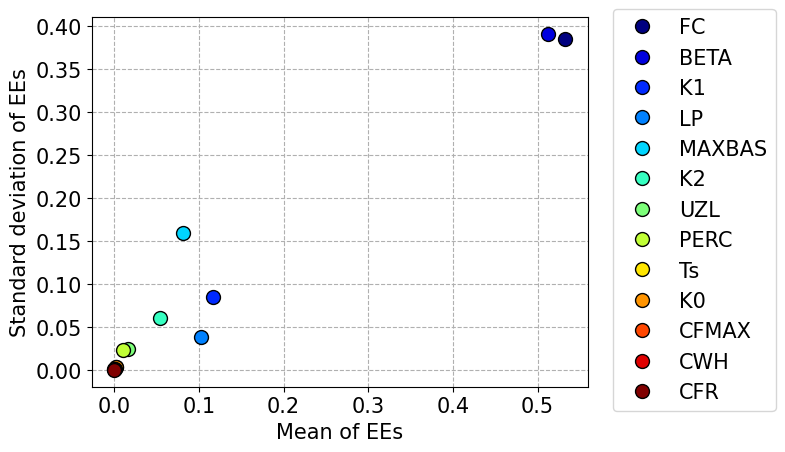

In [3]:
# define distribution
distr_fun = st.uniform # uniform distribution
distr_par = [np.nan] * n_parameters
for i in range(n_parameters):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]

# define the sampling design type
design_type = "radial"

# define the sampling strategy
sampling_strategy = "lhs"

n_EEs = 10 # number of model runs = n_EEs * (n_parameters + 1); due to One-At-the-Time sampling
parameter_sets = OAT_sampling(n_EEs, n_parameters, distr_fun, distr_par, sampling_strategy, design_type) 
# note: parameter_sets.shape = (r * (n_parameters + 1), n_parameters)

print(f"Number of model runs = {n_EEs} * ({n_parameters} + 1) = {parameter_sets.shape[0]}. This may take a while.\n") 
errors = np.nan * np.ones(parameter_sets.shape[0]) 
for i, parameter_set in enumerate(parameter_sets):
    errors[i], _ = hbv_and_one_obj_fun(parameter_set, P, T, PET, Q_obs, n_spinup_days, calc_nse) 

# Computation of the elementary effects (EEs)
mi, sigma, _ = EET.EET_indices(n_EEs, xmin, xmax, parameter_sets, errors, design_type)
# mi (mean of the elementary effects) and 
# sigma (standard deviation of the elementary effects) have shape (n_boot, n_parameters)

# Plot results in the plane (mean(EE), std(EE)):
EET.EET_plot(mi, sigma, parameter_names)

# Print result as a table
df_res = pd.DataFrame(np.array([parameter_names, mi, sigma]).T, 
                  columns=["Parameters", "Mean of EEs (x-axis)", "Standard deviation of EEs (y-axis)"])
df_res["Mean of EEs (x-axis)"] = df_res["Mean of EEs (x-axis)"].astype(float).round(4)
df_res["Standard deviation of EEs (y-axis)"] = df_res["Standard deviation of EEs (y-axis)"].astype(float).round(4)
print("Results:")
print(df_res)

---

### <div class="blue"><span style="color:blue">Exercise section</span></div>
### Exercise 1

(a) Which parameters can you ignore? What can you say about the remaining parameters?

* Answer

(b) Increase the value of n_EEs using the slider above. Why do the plotted results change?

* Answer

---

**Use bootstrapping to derive confidence bounds**

In [4]:
@interact(n_bootstrap = (10, 100, 10), n_EEs = (10, 100, 10))    
def conf_bounds_function(n_bootstrap = 10, n_EEs = 10):
    parameter_sets = OAT_sampling(n_EEs, n_parameters, distr_fun, distr_par, sampling_strategy, design_type) 
    print(f"Number of model runs = {n_EEs} * ({n_parameters} + 1) = {parameter_sets.shape[0]}. This may take a while.\n") 
    errors = np.nan * np.ones(parameter_sets.shape[0]) # note: parameter_sets.shape = (r * (n_parameters + 1), n_parameters)
    for i, parameter_set in enumerate(parameter_sets):
        errors[i], _ = hbv_and_one_obj_fun(parameter_set, P, T, PET, Q_obs, n_spinup_days, calc_nse) 
        
    # Compute sensitivity indices for Nboot bootstrap resamples:
    mi, sigma, EE = EET.EET_indices(n_EEs, xmin, xmax, parameter_sets, errors, design_type, Nboot=n_bootstrap)
    # mi (mean of the elementary effects) and 
    # sigma (standard deviation of the elementary effects) have shape (n_bootstrap, n_parameters)
    
    # Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples:
    mi_m, mi_lb, mi_ub = aggregate_boot(mi) # shape (M,)
    sigma_m, sigma_lb, sigma_ub = aggregate_boot(sigma) # shape (M,)
    
    df_res = pd.DataFrame(np.array([parameter_names, mi_m, sigma_m]).T, 
                      columns=["Parameters", "Mean of EEs (x-axis)", "Standard deviation of EEs (y-axis)"])
    df_res["Mean of EEs (x-axis)"] = df_res["Mean of EEs (x-axis)"].astype(float).round(4)
    df_res["Standard deviation of EEs (y-axis)"] = df_res["Standard deviation of EEs (y-axis)"].astype(float).round(4)
    print("Dots in the plot below:")
    print(df_res)

    # Plot bootstrapping results in the plane (mean(EE),std(EE)):
    EET.EET_plot(mi_m, sigma_m, parameter_names, mi_lb, mi_ub, sigma_lb, sigma_ub)
    plt.show()

    # Repeat computations using a decreasing number of samples so as to assess
    # if convergence was reached within the available dataset:
    rr = np.linspace(n_EEs/5, n_EEs, 5).astype(int) # Sample numbers at which the indices will be estimated
    # Compute sensitivity indices for Nboot bootstrap resamples:
    mic, sigmac = EET.EET_convergence(EE, rr, n_bootstrap) # mic and sigmac are lists in
    # which the i-th element correspond to the sensitivity indices at the i-th sample size
    
    # Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples:
    mic_m, mic_lb, mic_ub = aggregate_boot(mic)
    sigmac_m, sigmac_lb, sigmac_ub = aggregate_boot(sigmac)
    
    # Plot the sensitivity measure (mean of elementary effects) as a function of the number of model evaluations:
    plt.figure()
    pf.plot_convergence(mic_m, rr*(n_parameters+1), mic_lb, mic_ub,
                        X_Label='no of model evaluations', Y_Label='mean of EEs',
                        labelinput=parameter_names)
    plt.show()

interactive(children=(IntSlider(value=10, description='n_bootstrap', min=10, step=10), IntSlider(value=10, des…

---

### <div class="blue"><span style="color:blue">Exercise section</span></div>
### Exercise 2

(a) Why are the rectangular confidence intervals overlapping and how does that influence your interpretation about which parameter is most sensitive?

* Answer

(b) What parameter is most sensitive? What parameter shows the largest interactions?

* Answer

(c) At what point have you reached a convergence in sensitivity? Why is extending the original samples useful?

* Answer

---

## Jupyter format settings

In [5]:
%%html 
<style>.blue {background-color: #8dc9fc;}</style>